In [1]:
'Ref: https://towardsdatascience.com/insurance-risk-pricing-tweedie-approach-1d71207268fc
'

[1] "Ref: https://towardsdatascience.com/insurance-risk-pricing-tweedie-approach-1d71207268fc\n"

In [6]:
# Import / Install Libraries

In [219]:
library("tweedie")
library("insuranceData")
library("repr")
library("statmod")
library(ggplot2)
library(statmod)
library("rsq")
data(dataCar)
'ref: https://cran.r-project.org/web/packages/tweedie/tweedie.pdf'

Warning message:
"package 'rsq' was built under R version 3.6.3"

[1] "ref: https://cran.r-project.org/web/packages/tweedie/tweedie.pdf"

In [ ]:
# Set Parameters

In [96]:
options(repr.plot.width=5, repr.plot.height=4)

In [16]:
# Generate a Tweetie Distribution 

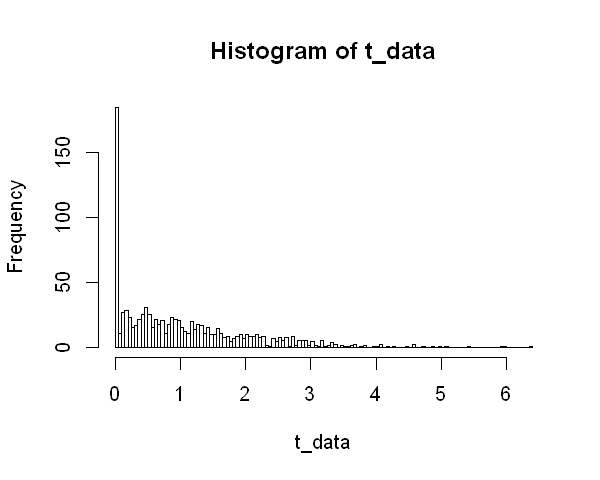

In [97]:
set.seed(1234)
n = 1000 # Number of observations to generate
xi = 1.4 # index parameter p, which determines the distribution
mu=1 # mean
phi=1 # Phi, another shape parameter.
t_data <- rtweedie(n, xi, mu, phi)
hist(t_data, breaks=100)

In [33]:
# Load | Inspect Dataset
'This dataset is based on one-year vehicle insurance policies taken out in 2004 or 2005. 
There are 67,856 policies, of which 4624 (6.8% notified claims) filed claims.'

[1] "This dataset is based on one-year vehicle insurance policies taken out in 2004 or 2005. \nThere are 67,856 policies, of which 4624 (6.8% notified claims) filed claims."

In [36]:
summary(dataCar)
help(dataCar)

   veh_value         exposure             clm            numclaims      
 Min.   : 0.000   Min.   :0.002738   Min.   :0.00000   Min.   :0.00000  
 1st Qu.: 1.010   1st Qu.:0.219028   1st Qu.:0.00000   1st Qu.:0.00000  
 Median : 1.500   Median :0.446270   Median :0.00000   Median :0.00000  
 Mean   : 1.777   Mean   :0.468651   Mean   :0.06814   Mean   :0.07276  
 3rd Qu.: 2.150   3rd Qu.:0.709103   3rd Qu.:0.00000   3rd Qu.:0.00000  
 Max.   :34.560   Max.   :0.999316   Max.   :1.00000   Max.   :4.00000  
                                                                        
   claimcst0          veh_body        veh_age      gender    area     
 Min.   :    0.0   SEDAN  :22233   Min.   :1.000   F:38603   A:16312  
 1st Qu.:    0.0   HBACK  :18915   1st Qu.:2.000   M:29253   B:13341  
 Median :    0.0   STNWG  :16261   Median :3.000             C:20540  
 Mean   :  137.3   UTE    : 4586   Mean   :2.674             D: 8173  
 3rd Qu.:    0.0   TRUCK  : 1750   3rd Qu.:4.000             

In [191]:
sum(is.na(dataCar$exposure))

[1] 0

In [79]:
head(dataCar)

veh_value,exposure,clm,numclaims,claimcst0,veh_body,veh_age,gender,area,agecat,X_OBSTAT_
1.06,0.3039014,0,0,0,HBACK,3,F,C,2,01101 0 0 0
1.03,0.6488706,0,0,0,HBACK,2,F,A,4,01101 0 0 0
3.26,0.5694730,0,0,0,UTE,2,F,E,2,01101 0 0 0
4.14,0.3175907,0,0,0,STNWG,2,F,D,2,01101 0 0 0
0.72,0.6488706,0,0,0,HBACK,4,F,C,2,01101 0 0 0
2.01,0.8542094,0,0,0,HDTOP,3,M,C,4,01101 0 0 0


In [66]:
w.claims <- sum(subset(dataCar, clm == 1)$clm)
w.out.claims <- dim(dataCar)[1] - w.claims
paste('With claims =>', w.claims)
paste('Without claims =>', w.out.claims)
paste('Pct w/ claims =>', round(w.claims / w.out.claims, 3)*100, '%')

[1] "With claims => 4624"

[1] "Without claims => 63232"

[1] "Pct w/ claims => 7.3 %"

In [ ]:
# Distribution Claim Cost

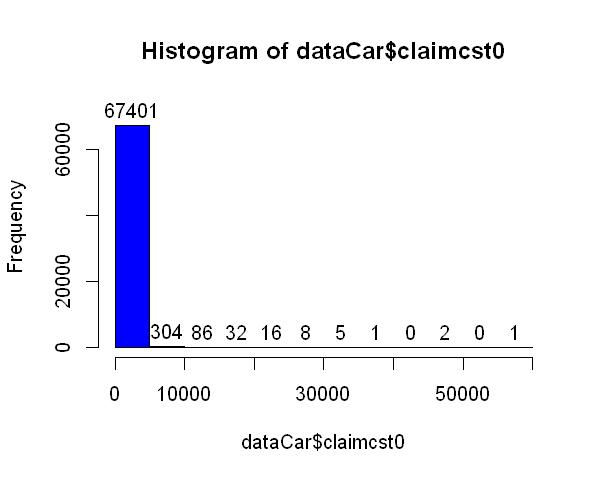

In [133]:
hist(dataCar$claimcst0, breaks=10, labels=TRUE, col='blue', ylim = c(0, 1.3*max(dataCar$claimcst0)))

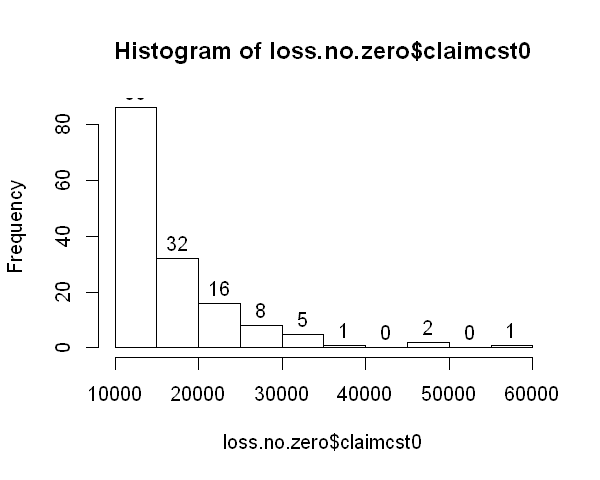

In [136]:
# Distribution without zeros
loss.no.zero <- subset(dataCar, claimcst0 > 10000)
hist(loss.no.zero$claimcst0, breaks=10, labels=TRUE)

In [ ]:
# Get Distribution All Independent Variables

In [173]:
col.names <- colnames(dataCar)

[1] "veh_value" "exposure"  "clm"       "numclaims" "claimcst0" "veh_body" 
 [7] "veh_age"   "gender"    "area"      "agecat"    "X_OBSTAT_"

In [201]:
unique(dataCar$veh_body)

[1] HBACK UTE   STNWG HDTOP PANVN SEDAN TRUCK COUPE MIBUS MCARA BUS   CONVT
[13] RDSTR
13 Levels: BUS CONVT COUPE HBACK HDTOP MCARA MIBUS PANVN RDSTR SEDAN ... UTE

In [137]:
# Determining the best distribution to fit the data
'- Normal Distribution:  clearly not normal 
 - Poisson: can also be discarded because this is not a count data. 
 - Gamma: but this distribution does not take zero values. 
 - Tweedie:  Only option and best fit for this data'

[1] "- Normal Distribution:  clearly not normal \n - Poisson: can also be discarded because this is not a count data. \n - Gamma: but this distribution does not take zero values. \n - Tweedie:  Only option and best fit for this data"

In [138]:
' Fitting Model

    Approach 1 — Manual selection of the variance power.
        Test a sequence of “p” between 1 to 2 by running iterative models.
        The Log-likelihood shows an inverse “U” shape.
        Select the “p” that corresponds to the “maximum” log-likelihood value.
        Fit the final model using that “p” value.

    Approach 2 — Automated selection of variance power using statistical packages
        Statistical packages (macros) are available in various software such as R, SAS, 
        Python, and Emblem (Industry-specific software) to calculate maximum likelihood estimate 
        for a series of “p” value. These are a kind of improvement to approach 1 with many other 
        added features such as visualization. We can see the sample output below in the form of a
        graph generated from R using the “Tweedie” package.
'

[1] " Fitting Model\n\n    Approach 1 — Manual selection of the variance power.\n        Test a sequence of “p” between 1 to 2 by running iterative models.\n        The Log-likelihood shows an inverse “U” shape.\n        Select the “p” that corresponds to the “maximum” log-likelihood value.\n        Fit the final model using that “p” value.\n\n    Approach 2 — Automated selection of variance power using statistical packages\n        Statistical packages (macros) are available in various software such as R, SAS, \n        Python, and Emblem (Industry-specific software) to calculate maximum likelihood estimate \n        for a series of “p” value. These are a kind of improvement to approach 1 with many other \n        added features such as visualization. We can see the sample output below in the form of a\n        graph generated from R using the “Tweedie” package.\n"

In [ ]:
# Profile Tweetie Model To Find Optimal P (power) value

In [149]:
help(tweedie.profile)

In [193]:
colnames(dataCar)
smp_size = round(0.3 * nrow(dataCar), 0)
train = dataCar[sample(nrow(dataCar), smp_size), ]
p.range <- seq(1, 2, 0.1)
p.range <- p.range[p.range != 1.8]

[1] "veh_value" "exposure"  "clm"       "numclaims" "claimcst0" "veh_body" 
 [7] "veh_age"   "gender"    "area"      "agecat"    "X_OBSTAT_"

[1] 1.0 1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.9 2.0

Warning message in model.matrix.default(mt, mf, contrasts):
"non-list contrasts argument ignored"

Values of p between 0 and 1 and less than zero have been removed: such values are not possible.
When the response variable contains exact zeros, all values of p must be between 1 and 2; other values have been removed.
1.1 1.2 1.3 1.4 1.5 1.6 1.7 1.9 
.......

Warning message:
"glm.fit: algorithm did not converge"

.

Warning message:
"step size truncated due to divergence"Warning message in tweedie.profile(claimcst0 ~ veh_value + veh_body + veh_age + :
"  Problem near  p  =  1.9 ; this error reported:
      Error in glm.fit(x = model.x, y = ydata, weights = weights, offset = offset,  : 
  NA/NaN/Inf in 'x'
  Examine the data and function inputs carefully."

Done.


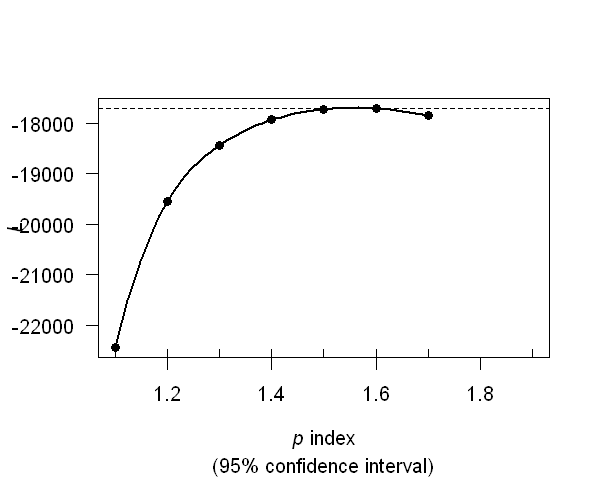

In [194]:
# link.power = logarithm link function.
est_p <- tweedie.profile(claimcst0 ~ veh_value+veh_body+veh_age+ gender+area+agecat,
                         p.vec=p.range, data=train,link.power=0, do.smooth = TRUE,
                         do.plot = TRUE)


In [ ]:
# Tweetie Implementation

In [235]:
tweedie_model <- glm(claimcst0 ~ veh_value+veh_body+veh_age+gender+ area+agecat,
                     data=train, family=tweedie(var.power=1.6, link.power=0),offset=log(exposure))

In [242]:
pred <- predict(tweedie_model, train)

In [236]:
sqrt(mean(tweedie_model$residuals^2))


[1] 54.92091